In [1]:
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np

# Initialize an empty list to store DataFrames
dfs = []

num_envs = 64

# Get a list of the data files
data_files = glob.glob('../logs/data_exp*_*.csv')

# Define the column names
column_names = ['reset_buf', 'progress_buf', 'thrust1', 'thrust2', 'thrust3', 'thrust4',
                'drone_x', 'drone_y', 'drone_z', 'hoop_x', 'hoop_y', 'hoop_z', 'reward', 'collision', 'target']

# Loop over the data files
for data_file in data_files:
    # Extract the experiment number and iteration from the file name
    match = re.search(r'data_exp(\d+)_(\d+).csv', data_file)
    experiment = int(match.group(1))
    iteration = int(match.group(2))

    # Load the data
    df = pd.read_csv(data_file, names=column_names)
    
    # Add columns for the environment number and split number
    df['env_num'] = np.arange(len(df)) % num_envs
    df['split_num'] = 0

    # Update the split numbers
    for i in range(0, num_envs):
        data_env = df[df['env_num'] == i]
        splits = np.where(data_env['reset_buf'] == 1)[0]
        for j, (start, end) in enumerate(zip(np.r_[0, splits+1], np.r_[splits+1, len(data_env)])):
            df.loc[data_env.index[start:end], 'split_num'] = j
    

    # Add columns for the experiment number and iteration
    df['experiment'] = experiment
    df['iteration'] = iteration

    # Append the DataFrame to the list
    dfs.append(df)

# Concatenate all the DataFrames in the list
df = pd.concat(dfs, ignore_index=True)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df.head()

,reset_buf,progress_buf,thrust1,thrust2,thrust3,thrust4,drone_x,drone_y,drone_z,hoop_x,hoop_y,hoop_z,reward,collision,target,env_num,split_num,experiment,iteration
0,0.0,1.0,0.0,0.0,0.0,0.0,-0.520746,-0.555458,0.949738,-0.283279,-2.225996,1.133172,1.546099,0.0,0.0,0,0,2,3
1,0.0,1.0,0.0,0.0,0.0,0.0,1.490176,-0.578826,1.665863,-0.402564,-2.160758,1.037765,0.802194,0.0,0.0,1,0,2,3
2,0.0,1.0,0.0,0.0,0.0,0.0,-1.288068,0.336351,1.371516,-0.341399,-2.303468,1.146715,0.672996,0.0,0.0,2,0,2,3
3,0.0,1.0,0.0,0.0,0.0,0.0,-0.632081,-0.823704,1.634222,-0.206087,-2.200256,1.251251,1.861601,0.0,0.0,3,0,2,3
4,0.0,1.0,0.0,0.0,0.0,0.0,0.011169,-1.185539,0.639211,0.270127,-2.458707,1.267392,1.946390,0.0,0.0,4,0,2,3


In [25]:
df.to_csv('../logs/data_split.csv', index=False)

In [10]:
#create a key column with the concatenation of 'experiment','iteration','env_num', 'split_num'
df['key'] = df['experiment'].astype(str) + '_' + df['iteration'].astype(str) + '_' + df['env_num'].astype(str) + '_' + df['split_num'].astype(str)

grouped = df.groupby(['experiment','iteration','env_num', 'split_num','key'])
# Define a function that checks if there's at least one collision in a group
def has_collision(group):
    return group['collision'].any()

# Group the data by environment and split, and apply the function
collision_groups = grouped.apply(has_collision)

# Count the number of splits with at least one collision per environment
collision_counts_env = collision_groups.groupby(['experiment','iteration','env_num']).sum()
collision_counts_ite = collision_groups.groupby(['experiment','iteration']).sum()
collision_counts_exp = collision_groups.groupby(['experiment']).sum()


# Count the number of splits per environment
split_counts_env = df.groupby(['experiment','iteration','env_num'])['key'].nunique()
split_counts_ite = df.groupby(['experiment','iteration'])['key'].nunique()
split_counts_exp = df.groupby(['experiment'])['key'].nunique()



# Calculate the rate of collision
collision_rate_env = collision_counts_env / split_counts_env
collision_rate_ite = collision_counts_ite / split_counts_ite
collision_rate_exp = collision_counts_exp / split_counts_exp

# Calculate the total number of collisions and splits
total_collisions_env = collision_counts_env.sum()
total_splits_env = split_counts_env.sum()

total_collisions_ite = collision_counts_ite.sum()
total_splits_ite = split_counts_ite.sum()

total_collisions_exp = collision_counts_exp.sum()
total_splits_exp = split_counts_exp.sum()


# Calculate the overall collision rate
overall_collision_rate_env = total_collisions_env / total_splits_env
overall_collision_rate_ite = total_collisions_ite / total_splits_ite
overall_collision_rate_exp = total_collisions_exp / total_splits_exp



print("Rate of collision per iteration:")
print(collision_rate_ite_plot)
print()

print("Rate of collision per experiment:")
print(collision_rate_exp)
print()


Rate of collision per iteration:
experiment  iteration
1           1            0.074649
            2            0.096461
            3            0.031523
            4            0.029569
            5            0.029569
2           1            0.022298
            2            0.039748
            3            0.103248
            4            0.026699
            5            0.063984
dtype: float64

Rate of collision per experiment:
experiment
1    0.052356
2    0.051202
dtype: float64



In [18]:
total_splits_exp

20626

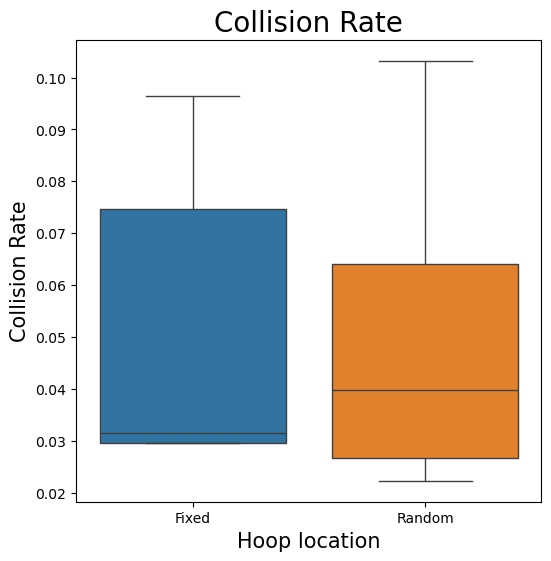

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reset the index of the DataFrame to make 'experiment' and 'iteration' regular columns
collision_rate_ite_plot = collision_rate_ite.reset_index()

# Rename the 0 column to 'collision_rate'
collision_rate_ite_plot = collision_rate_ite_plot.rename(columns={0: 'collision_rate'})

# Replace the 'experiment' column values
collision_rate_ite_plot['experiment'] = collision_rate_ite_plot['experiment'].replace({1: 'Fixed', 2: 'Random'})

# Create a boxplot of the collision rates by iteration with hue as experiment
plt.figure(figsize=(6, 6))
box_plot = sns.boxplot(x='experiment', y='collision_rate', hue='experiment', data=collision_rate_ite_plot)

# Set the title and labels, increase their font sizes
box_plot.set_title('Collision Rate', fontsize=20)
box_plot.set_xlabel('Hoop location', fontsize=15)
box_plot.set_ylabel('Collision Rate', fontsize=15)

plt.show()

In [15]:
# Define a function that checks if there's at least one target in a group
def has_target(group):
    return group['target'].any()

# Group the data by environment and split, and apply the function
target_groups = grouped.apply(has_target)

# Count the number of splits with at least one target per environment
target_counts_env = target_groups.groupby(['experiment','iteration','env_num']).sum()
target_counts_ite = target_groups.groupby(['experiment','iteration']).sum()
target_counts_exp = target_groups.groupby(['experiment']).sum()

# Calculate the rate of target
target_rate_env = target_counts_env / split_counts_env
target_rate_ite = target_counts_ite / split_counts_ite
target_rate_exp = target_counts_exp / split_counts_exp

# Calculate the total number of targets and splits
total_targets_env = target_counts_env.sum()
total_targets_ite = target_counts_ite.sum()
total_targets_exp = target_counts_exp.sum()

# Calculate the overall target rate
overall_target_rate_env = total_targets_env / total_splits_env
overall_target_rate_ite = total_targets_ite / total_splits_ite
overall_target_rate_exp = total_targets_exp / total_splits_exp

print("Rate of target per iteration:")
print(target_rate_ite)
print()

print("Rate of target per experiment:")
print(target_rate_exp)
print()

Rate of target per iteration:
experiment  iteration
1           1            0.969462
            2            0.915172
            3            0.959263
            4            0.966554
            5            0.966554
2           1            0.949103
            2            0.951527
            3            0.902084
            4            0.966990
            5            0.950073
dtype: float64

Rate of target per experiment:
experiment
1    0.955400
2    0.943949
dtype: float64



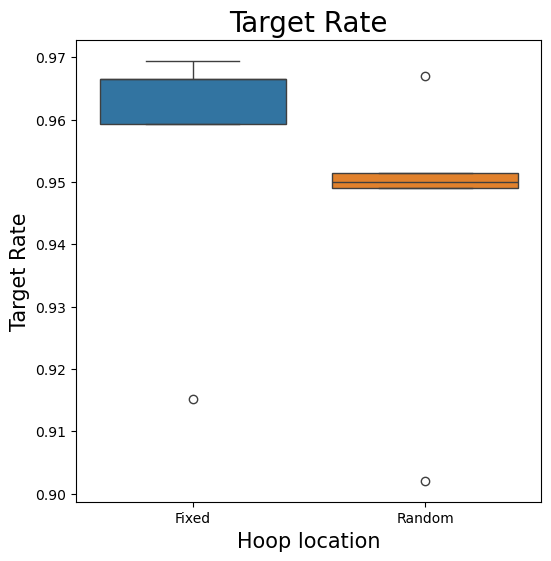

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reset the index of the DataFrame to make 'experiment' and 'iteration' regular columns
target_rate_ite_plot = target_rate_ite.reset_index()

# Rename the 0 column to 'target_rate'
target_rate_ite_plot = target_rate_ite_plot.rename(columns={0: 'target_rate'})

# Replace the 'experiment' column values
target_rate_ite_plot['experiment'] = target_rate_ite_plot['experiment'].replace({1: 'Fixed', 2: 'Random'})

# Create a boxplot of the target rates by iteration with hue as experiment
plt.figure(figsize=(6, 6))
box_plot = sns.boxplot(x='experiment', y='target_rate', hue='experiment', data=target_rate_ite_plot)

# Set the title and labels, increase their font sizes
box_plot.set_title('Target Rate', fontsize=20)
box_plot.set_xlabel('Hoop location', fontsize=15)
box_plot.set_ylabel('Target Rate', fontsize=15)

plt.show()

/tmp/ipykernel_83943/4231946818.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_target['reward'], kde=False)


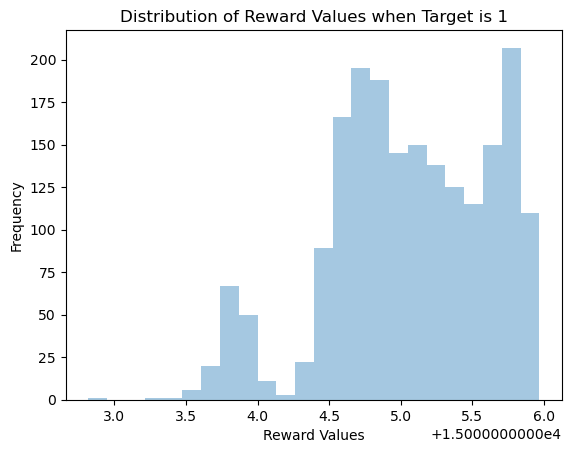

/tmp/ipykernel_83943/4231946818.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_target['progress_buf'], kde=False)


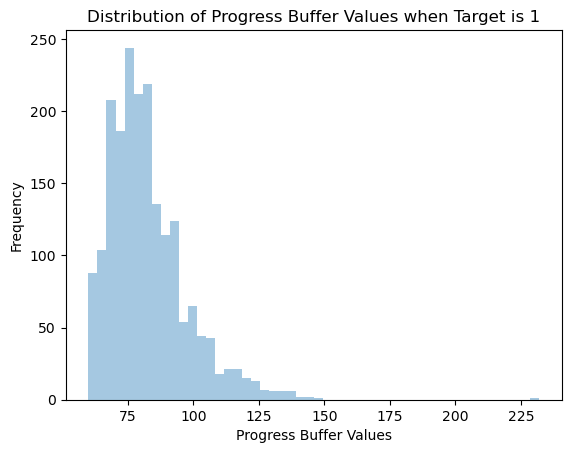

In [99]:
# Create a distribution plot of the reward column when target is 1
sns.distplot(df_target['reward'], kde=False)
plt.title('Distribution of Reward Values when Target is 1')
plt.xlabel('Reward Values')
plt.ylabel('Frequency')
plt.show()

# Create a distribution plot of the progress_buf column when target is 1
sns.distplot(df_target['progress_buf'], kde=False)
plt.title('Distribution of Progress Buffer Values when Target is 1')
plt.xlabel('Progress Buffer Values')
plt.ylabel('Frequency')
plt.show()